<a href="https://colab.research.google.com/github/avneesh-nolkha/EVA5/blob/master/Session10/EVA5_Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision import transforms

In [2]:
!pip install git+https://github.com/smitasasindran/eva5utils.git

  Cloning https://github.com/smitasasindran/eva5utils.git to /tmp/pip-req-build-v18885cr
  Running command git clone -q https://github.com/smitasasindran/eva5utils.git /tmp/pip-req-build-v18885cr
     |████████████████████████████████| 634kB 5.0MB/s 
  Created wheel for eva5utils: filename=eva5utils-0.1.0-cp36-none-any.whl size=20579 sha256=5c5c552dee138f6800377c92a59f493a8d5f6fbe3d0062dafc605fba66f1263f
  Stored in directory: /tmp/pip-ephem-wheel-cache-bgx0di9k/wheels/c6/bb/ac/e3952b213bfdb25cb23715782e1a6b4b4b5cb10e42a2b80aa9
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=55304de262fb517ae566ffe5ac5c1a016a0ebc5cae0cb7d921937e343d71078c
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built eva5utils imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [4]:
from eva5utils.dataloaders import load_cifar10
from eva5utils.model import Model7, ResNet18
from eva5utils.transforms import model9_resnet_train_transforms, model9_resnet_test_transforms, model10_resnet_train_transforms
from eva5utils.train import train_loop
from eva5utils.test import test_loop
from eva5utils.utils import plot_samples, LRFinder, TrainDataLoaderIter, ValDataLoaderIter, plot_misclassified_gradcam
from eva5utils.utils.helpers import show_model_summary, DEVICE, IS_CUDA, accuracy_per_class, show_gradcam, find_misclassified

In [5]:
# Constants, put in config
epochs = 50
cuda_batch_size=128
cpu_batch_size = 4
num_workers = 4


model = ResNet18()
show_model_summary(model.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [6]:
# Load datasets
(trainloader, testloader, classes) = load_cifar10(model10_resnet_train_transforms(), model9_resnet_test_transforms(), cuda_batch_size, cpu_batch_size, num_workers)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
print(DEVICE)
torch.cuda.is_available()

cuda


True

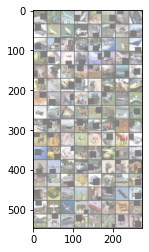

In [8]:
plot_samples(trainloader)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.45E-02


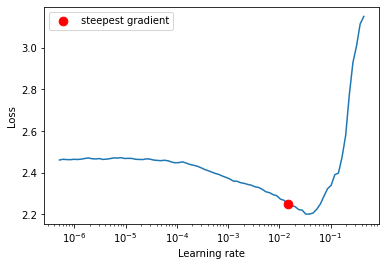

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device=DEVICE)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
# Training loop
optimizer = optim.SGD(model.parameters(), lr=1.45E-02 , momentum=0.9)         #3.85E-02, 2.18E-02
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=.2)
train_loss, train_acc = train_loop(epochs, trainloader, model, DEVICE, optimizer, criterion, scheduler, True)

[1,   391] loss: 563.261
[2,   391] loss: 375.269
[3,   391] loss: 285.749
[4,   391] loss: 241.879
[5,   391] loss: 204.248
[6,   391] loss: 179.909
[7,   391] loss: 159.071
[8,   391] loss: 142.878
[9,   391] loss: 128.434
[10,   391] loss: 114.127
[11,   391] loss: 104.300
[12,   391] loss: 93.822
[13,   391] loss: 86.806
[14,   391] loss: 77.101
[15,   391] loss: 70.790
[16,   391] loss: 66.520
[17,   391] loss: 60.723
[18,   391] loss: 57.187
[19,   391] loss: 51.858
[20,   391] loss: 48.427
[21,   391] loss: 45.905
[22,   391] loss: 42.619
[23,   391] loss: 40.117
[24,   391] loss: 40.274
[25,   391] loss: 36.317
[26,   391] loss: 34.680
[27,   391] loss: 33.402
[28,   391] loss: 30.614
[29,   391] loss: 31.375
[30,   391] loss: 31.153
[31,   391] loss: 30.340
[32,   391] loss: 26.666
[33,   391] loss: 28.127
[34,   391] loss: 26.927
[35,   391] loss: 25.144
[36,   391] loss: 25.460
[37,   391] loss: 24.243
[38,   391] loss: 22.779
[39,   391] loss: 21.693
[40,   391] loss: 20.55

In [11]:
# Test Loop

test_loss, test_acc = test_loop(testloader, model, DEVICE, criterion)
accuracy_per_class(model, classes, testloader, DEVICE)

Accuracy of the network on the 10000 test images: 89 %, Test loss: 1521.5073491930962
Accuracy of plane : 88 %
Accuracy of   car : 95 %
Accuracy of  bird : 83 %
Accuracy of   cat : 82 %
Accuracy of  deer : 95 %
Accuracy of   dog : 86 %
Accuracy of  frog : 81 %
Accuracy of horse : 92 %
Accuracy of  ship : 94 %
Accuracy of truck : 84 %


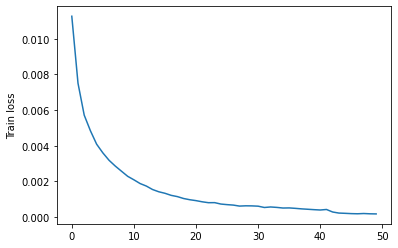

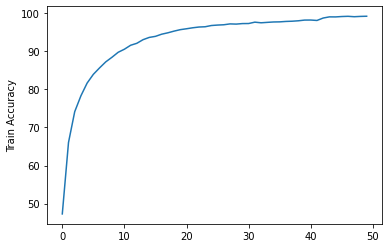

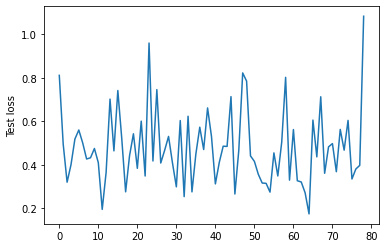

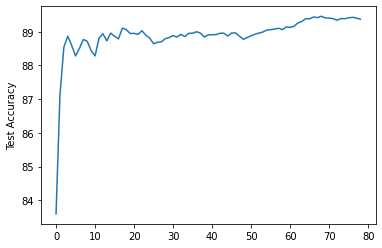

In [12]:
plt.plot(train_loss)
plt.ylabel('Train loss')
plt.show()

plt.plot(train_acc)
plt.ylabel('Train Accuracy')
plt.show()

plt.plot(test_loss)
plt.ylabel('Test loss')
plt.show()

plt.plot(test_acc)
plt.ylabel('Test Accuracy')
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


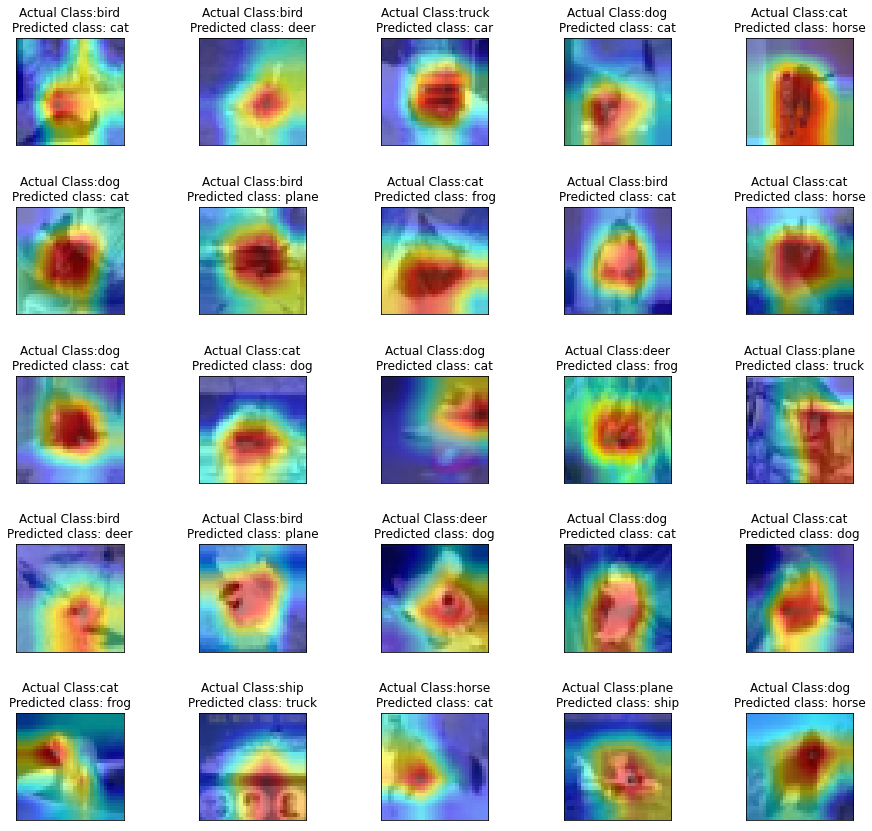

In [13]:
# Show gradcam missclassified images
missclassified = find_misclassified(model, testloader)
plot_misclassified_gradcam(model, missclassified, classes, 'layer4', model_type='resnet')